# Patterns of Jeopardy! questions <font style="color:rgb(0,100,200)"><i>(Work in progress)</i></font>

Jeopardy! is a popular American televised quizz competition. 
It has now aired more than 8000 episodes, was adapted in many other countries, and was ranked in 2013 among the 60 greatest shows in American television history by [TV Guide](https://www.tvguidemagazine.com/).
More information can be found on [this wikipedia page](https://en.wikipedia.org/wiki/Jeopardy!). 
In this project, we will study a set of questions and answers which appeared in the show and try to find patterns which may help a candidate prepare for the game. 

## Data Cleaning

The dataset, `JEOPARDY_CSV.csv`, can be found on [this reddit thread](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/). 
It contains 216,930 jeopardy questions and answers among the 252,583 which had been asked at the time of posting. 
Its columns are: 
* `category`: the question category, 
* `value`: the amount of money the question is worth (“None” for Final Jeopardy! and Tiebreaker questions),
* `question`: text of the question,
* `answer`: text of the answer,
* `round`: the round of Jeopardy that the question was asked in: “Jeopardy!”, “Double Jeopardy!”, “Final Jeopardy!”, or “Tiebreaker”,
* `show_number` : the episode number the question was asked in,
* `air_date`: the show air date in format YYYY-MM-DD.

Let us first import the modules we will need: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We then read the dataset in the dataframe `jeopardy` and print its first five rows:

In [2]:
jeopardy = pd.read_csv('../Data/JEOPARDY_CSV.csv')
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


Let us check the column names:

In [3]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

Some of them have a leading space. 
Let us get rid of it:

In [4]:
def delete_leading_spaces(s):
    '''
    Returns the string s stripped of leading spaces
    '''
    while s[0] == ' ':
        s = s[1:]
    return s

jeopardy.columns = map(delete_leading_spaces, jeopardy.columns)
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

Let us now check for missing values: 

In [5]:
jeopardy.isnull().sum()

Show Number    0
Air Date       0
Round          0
Category       0
Value          0
Question       0
Answer         2
dtype: int64

There are two missing values in the `Answer` column. 
Let us see where they are:

In [6]:
jeopardy[jeopardy['Answer'].isnull()]

,Show Number,Air Date,Round,Category,Value,Question,Answer
94817,4346,2003-06-23,Jeopardy!,"GOING ""N""SANE",$200,"It often precedes ""and void""",NaN
143297,6177,2011-06-21,Double Jeopardy!,NOTHING,$400,"This word for ""nothing"" precedes ""and void"" to...",NaN


The Answer to these two questions is “Null”, which seems to have confused Pandas when importaing the file. 
Let us correct this error: 

In [7]:
jeopardy.fillna('Null', inplace=True)
jeopardy.isnull().sum()

Show Number    0
Air Date       0
Round          0
Category       0
Value          0
Question       0
Answer         0
dtype: int64

We now convert the `Show Number` and `Value` column to integers:

In [8]:
jeopardy['Show Number'] = jeopardy['Show Number'].astype(int)
jeopardy['Value'] = jeopardy['Value'].str.replace('$','').str.replace(',','').replace('None',np.nan).astype(float)

Finally, let us convert the `Air Date` column to datetime format:

In [9]:
jeopardy['Air Date'] = pd.to_datetime(jeopardy['Air Date'], format = '%Y-%m-%d')

We can use this to see in which year the questions present in the dataset were asked.

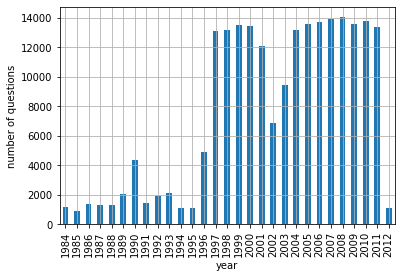

In [10]:
jeopardy['Air Date'].dt.year.value_counts(sort=False).plot(kind='bar')
plt.xlabel('year')
plt.ylabel('number of questions')
plt.grid()
plt.show()

Most of the questions present in the dataset were asked between 1997 and 2011, with a few questions asked between 1984 and 1995. 
It would be interesting to see if the increase in the number of questions in and after 1996 as well as the drop in 2002 can be explained. 
But this is beyond the scope of the present study.

The small number of questions for 2012 may be due to the fact that the dataset covers only the beginning of that year. 
Let us check this:

In [11]:
jeopardy[jeopardy['Air Date'].dt.year == 2012]['Air Date'].dt.month.value_counts()

1    1093
Name: Air Date, dtype: int64

The dataset extends only to January 2012. 
It is thus not surprizing to have only a few questions for that year. 

Let us now normalize the columns `Question` and `Answer` by converting them to lowercase and replacing punctuation marks with spaces:

In [12]:
jeopardy['Question'] = jeopardy['Question'].str.replace('\W',' ').str.lower()
jeopardy['Answer'] = jeopardy['Answer'].str.replace('\W',' ').str.lower()

## Data Analysis

### How often is the answer in the question?

One possible tactic to find for the answer to a question is to look at question itself and see if it may contain part of the answer. 
Let us estimate how frequenctly it may succeed by counting the average fraction of words of the answer which are included in the question, excluding the word “the” which appear commonly in answers but does not change their meaning. 

In [13]:
def fraction_answer_in_question(row):
    '''
    Returns the fraction of the number of words in the answer which are present in the question
    '''
    words_answer = row['Answer'].split(' ')
    if 'the' in words_answer:
        words_answer.remove('the')
    # if the answer is empty, return 0
    if len(words_answer) == 0: 
        return 0
    words_question = row['Question'].split()
    match_word = 0
    for word in words_answer:
        if word in words_question:
            match_word += 1
    return match_word / len(words_answer)

jeopardy['Answer in question'] = jeopardy.apply(fraction_answer_in_question, axis=1)
print('Fraction of words in answers appearing in questions: {:.2f}%'.format(100*jeopardy['Answer in question'].mean()))

Fraction of words in answers appearing in questions: 5.84%


The fraction of words in the answers appearing in the corresponding questions is close to 6%, which is not a lot. 
Looking for the answer in the question can thus give a candidate only a limited boost (although it may be useful for winning close games).

### How often are questions recycled? 

Let us now estimate the fraction of words in each question which has been recycled. 
We exclude words with 5 letters of less, as many of them are common words which contribute little to the actual meaning of the question.
A sufficiently long word will be called recycled if it has already appeared in an earlier question. 

Let us first sort the `jeopardy` dataframe by air date:

In [14]:
jeopardy = jeopardy.sort_values('Air Date')

We now compute the fraction of each question which has been recycled, and save it in the `Fraction of Question Recycled` column:

In [15]:
vocabulary = set([]) 
fraction_recycled = []
for question in jeopardy['Question']:
    words_question = question.split(' ')
    match_count = 0
    word_count = 0
    for word in words_question:
        if len(word) >= 6:
            word_count += 1
            if word in vocabulary:
                match_count += 1
            else: 
                vocabulary.add(word)
    # if there is no long enough word, return 0
    if word_count == 0:
        fraction_recycled.append(0)
    else: 
        fraction_recycled.append(match_count / word_count)
        
jeopardy['Fraction of Question Recycled'] = fraction_recycled
print('Fraction of recycled questions: {:.2f}%'.format(100*jeopardy['Fraction of Question Recycled'].mean()))

Fraction of recycled questions: 89.92%


The fraction of recycled long words in questions is close to 90%. 
It thus seems that studying previous questions can give a good idea of which questions may be asked. 

Let us plot the evolution of the fraction of recycled questions with years:

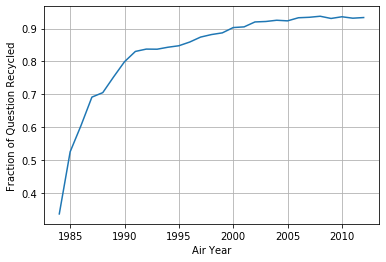

In [16]:
jeopardy['Air Year'] = jeopardy['Air Date'].dt.year
jeopardy.groupby('Air Year').mean()['Fraction of Question Recycled'].plot()
plt.grid()
plt.ylabel('Fraction of Question Recycled')
plt.show()

The fraction of questions recycled has increased fast before 1990, before going above 90% in 2000 and staying nearly stable since then.

### Most-used words in high-value questions

Let us now determine the most-used words, focusing on questions with high values. 
Let us first plot a histogram of the question values to determine which of them may count as high-value:

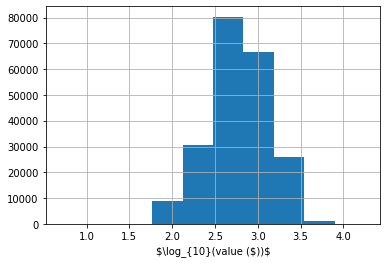

In [17]:
(np.log(jeopardy['Value'])/np.log(10)).hist()
plt.xlabel('$\log_{10}(value ($))$')
plt.show()

The peak of the distribution seems to be somewhere between \\$300 and \\$1000. 
Let us take \\$800 as a threshold.

In [18]:
nwords = 10
threshold = 800
freq_words_questions = {}
for _, row in jeopardy.iterrows():
    if row['Value'] >= threshold:
        words_question = row['Question'].split(' ')
        for word in words_question:
            if len(word) >= 6:
                if word in freq_words_questions:
                    freq_words_questions[word] += 1
                else:
                    freq_words_questions[word] = 1
sorted(freq_words_questions.items(), key=lambda item: -item[1])[:nwords]

[('archive', 8328),
 ('target', 6969),
 ('_blank', 6937),
 ('country', 2535),
 ('called', 2503),
 ('american', 1542),
 ('president', 1376),
 ('became', 1371),
 ('french', 1368),
 ('before', 1232)]

The words “archive”, “target”, and “_blank” do not provide much information (and the first and third seem to mostly appear in media contents of questions, such as urls). 
Discarding them, we find that the most used words in high-value questions are “country”, “called”, “american”, and “president”. 
A candidate who wants to earn a lot of money at Jeopardy! should thus study the world geography and American history.

### Most frequenct categories

To help a future candidate prepare for the game, it is useful to know which categories are most represented. 
Let us first see which of them appear most in all questions: 

In [19]:
res = jeopardy['Category'].value_counts()
print(res.head(5))
print('Percentage of questions covered: {:.2f}'.format(100*(res.head(5).sum()/res.sum())))

BEFORE & AFTER      547
SCIENCE             519
LITERATURE          496
AMERICAN HISTORY    418
POTPOURRI           401
Name: Category, dtype: int64
Percentage of questions covered: 1.10


These five categories taken together account for just over 1% of all questions asked. 
To be succesful, a candidate should thus study a broad range of topics instead of focusing on a few questions.

Let us now restrict ourselves to high-value questions, with a thresholf of 800USD:

In [20]:
threshold = 800
res = jeopardy[jeopardy['Value'] >= threshold]['Category'].value_counts()
print(res.head(5))
print('Percentage of questions covered: {:.2f}'.format(100*(res.head(5).sum()/res.sum())))

BEFORE & AFTER             304
LITERATURE                 201
SCIENCE                    198
OPERA                      150
COLLEGES & UNIVERSITIES    141
Name: Category, dtype: int64
Percentage of questions covered: 1.07


The first three categories are the same as for all questions, with the ranks of “Literature” and “Science” exchanged. 
The five most frequenct categories again cover only a small fraction of all questions. 

Finally, let us see which categories have the highest total values:

In [21]:
n_categories = 5
res = jeopardy.groupby('Category')['Value'].sum().sort_values(ascending=False)
print('Highest value categories')
print(res.head(n_categories))
print('Fraction of the total value covered: {:.2f}%'.format(100*res.head(n_categories).sum()/res.sum()))

Highest value categories
Category
BEFORE & AFTER    491900.0
SCIENCE           361221.0
LITERATURE        344900.0
OPERA             254300.0
WORD ORIGINS      251600.0
Name: Value, dtype: float64
Fraction of the total value covered: 1.06%


The three categories with a highest value are the same as the most frequent ones. 
We also find that they account for a small fraction of the total value only.

## Conclusion

In this short project, we looked at some statistics of the Jeopardy! questions and answers. 
We found that: 
* On average, a bit less that 6% of the answer is already in the question. 
Looking for the answer in the question can thus give a candidate a small advantage only. 
* More than 90% of questions asked after the year 2000 had already been asked before. 
A good strategy a future candidate can follow to be successful is thus to study previously-asked questions.
* The three categories which appear most frecuently are “Before & after”, “Science”, and “Literature”. 
However, they account for only just over 1% of all questions. 
A future candidate should thus study a broader range of topics to be successful. 